小编每周都要更新最近12周的“生产订单周报”给老板，而且要对比最近两年相同周数的数据。主要是两张图，一张是“一周生产订单对比”，另一张是“各部门订单比例”。虽然在Excel表中建了数据透视表，但是每周都还是需要花时间进行一通凶猛的操作，才能搞定。可不可以每周一键更新，并得到这两张图呢？
![](images\result.png)

导入`pandas`库，并读取原始表格。由于这个表格是文员手工记录，所以有些单元格可能漏填了，读取出来会显示为"NaN"，所以需要使用`fillna`将所有"NaN"的数据填充为“0”。`inplace = True`表示在原`dataframe`中更新，不然会更新后生成新的`dataframe`。由于数量列都是整数，而读取出来的数据是浮点型`float`，所以使用`astype`将数据转换为整型。为什么要转换呢？还是考虑到后面在柱状图上的显示问题，如果保持浮点型，“291”会显示成“291.0”，那就不专业了啊。

In [1]:
import pandas as pd
file = '生产订单.xlsx'
df = pd.read_excel(file)
df.fillna(0,inplace = True)
df["数量"] = df["数量"].astype('int')
df.dtypes

部门              object
产品编号            object
订单              object
文件              object
数量               int32
日期      datetime64[ns]
dtype: object

因为我们是要按年和周数来汇总数据，而原表没有这两个字段，所以需要新增。周数和年份直接来自原表的“日期”字段，分别使用`dt.week`和`dt.year`就能得到。

In [2]:
#增加周数字段
df["周数"] = df["日期"].dt.week
df["年份"] = df["日期"].dt.year
df.head()

,部门,产品编号,订单,文件,数量,日期,周数,年份
0,PZ,Y2P-047-XX-99904,O239156,DOC-PZ-1812001,1,2019-01-02,1,2019
1,GC,J1THXX1-XX-99901,O239157,DOC-18-1824,150,2019-01-02,1,2019
2,GC,J1THXX1-XX-99901,O239158,DOC-18-1825,1200,2019-01-02,1,2019
3,GC,N0TTXX2-XX-99901,O239160,DOC-18-1591,117,2019-01-02,1,2019
4,GC,Y3LXXX1-XX-99901,O239165,DOC-18-1802,90,2019-01-02,1,2019


每周更新数据的时候，都希望自动选取最近的12周，所以需要获取当前的周数，因此增加了如下程序。`isocalendar()`可将日期转换成由年份、周数、当周的天数组成的元组。其中第二个值就是周数。

In [3]:
#获取当前周数
import datetime
year,current_week,day = datetime.datetime.now().isocalendar()
current_week

27

由于只获取最近12周的数据，所以需要加入筛选语句如下。这样2019年和2020年对应的12周的数据都提取出来了。

In [4]:
#只获取最近12周的数据
df_required = df[(df["周数"] >= (current_week-12)) & (df["周数"] <= (current_week-1))]
df_required.head()

,部门,产品编号,订单,文件,数量,日期,周数,年份
153,GC,J1TH011-XX-99901,O276010,DOC-19-284,150,2019-04-09,15,2019
154,GC,Y2P-241-XX-99904,O278550,DOC-19-314,96,2019-04-12,15,2019
155,GC,Y2P-214BXX-99901,O278552,DOC-19-318,45,2019-04-12,15,2019
156,SG,Y1TSXX1-XX-99901,O279987,DOC-SG-1904008,8,2019-04-16,16,2019
157,GC,Y2P-241-XX-99905,O280009,DOC-19-322,80,2019-04-16,16,2019


然后开始按周数和年份分组，其对应的数量加总，得到新的`dataframe`“result”。

In [5]:
result=df_required.groupby(["周数","年份"])['数量'].sum().reset_index()#reset后才是DF，不然是Series
result.head()

,周数,年份,数量
0,15,2019,291
1,15,2020,687
2,16,2019,1745
3,16,2020,1536
4,17,2019,482


In [6]:
result[result["年份"]==2019]["数量"]

0      291
2     1745
4      482
6      352
8      416
10     480
12     145
14    1198
16     298
18     329
20     162
22    1430
Name: 数量, dtype: int32

数据整理好后，就可以开始绘制图表了。这里统一使用`matplotlib`来绘图。需要注意，如果图表有中文，必须配置中文字体，不然会显示成方框。然后通过`rcParams`设置全局字体大小，`figsize`设置图片大小。然后调用`plt.bar`进行柱状图绘制，将数据，颜色，图例等传入。再设置标题，数据标签等。最后保存图片，这样就搞定了一张图。

In [7]:
%matplotlib inline
#以上用于在notebook中显示绘图

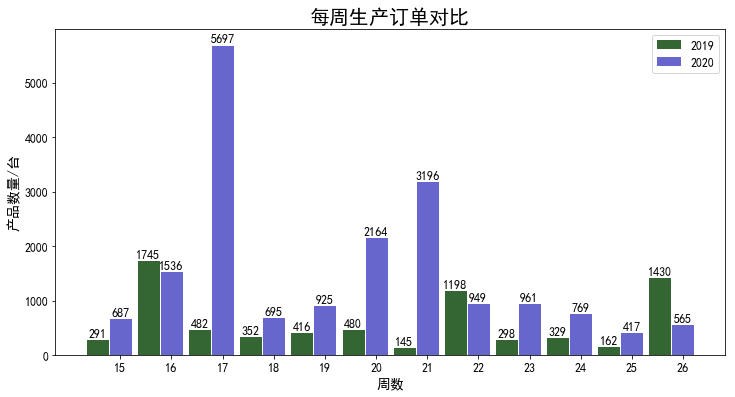

In [13]:
# 如果有中文，需要配置中文字体，不然会显示成方框
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
#数据和标签
qty_2019 = result[result["年份"]==2019]["数量"]
qty_2020 = result[result["年份"]==2020]["数量"]
x_label = result[result["年份"]==2019]["周数"]
 
#设置字体大小
mpl.rcParams['font.size'] = 12
#设置图片大小
plt.figure(figsize=(12, 6))
# 设置柱形图宽度
bar_width = 0.45

index = np.arange(12)
# 绘制2019年数据
qty1 = plt.bar(index, qty_2019, bar_width, color='#336633', label="2019")
# 绘制2020年数据
qty2 = plt.bar(index + bar_width, qty_2020, bar_width, color='#6666CC', label="2020")

# X,Y轴标题
plt.xticks(index + bar_width, x_label)
plt.xlabel("周数", fontsize = 14 )
plt.ylabel("产品数量/台", fontsize = 14 )
# 图表标题
plt.title(u'每周生产订单对比', fontsize = 20)
# 图例显示
plt.legend()
# 添加数据标签
def add_labels(qtys):
    for qty in qtys:
        height = qty.get_height()
        plt.text(qty.get_x() + qty.get_width() / 2, height, height, ha='center', va='bottom')
        # 柱形图边缘用白色填充
        qty.set_edgecolor('white')
add_labels(qty1)
add_labels(qty2)

plt.savefig('prod_order.png')

然后整理一下数据，继续绘制第二张图。这里是按部门计算订单数量，是计数，不是求和，因此使用`value_counts()`。

In [9]:
#按部门计算订单数量
order_2019 = df_required[df_required["年份"]==2019]
dept_2019 = order_2019["部门"].value_counts()
order_2020 = df_required[df_required["年份"]==2020]
dept_2020 = order_2020["部门"].value_counts()

In [10]:
dept_2019.index

Index(['GC', 'PZ', 'SG', 'GG', 'MJ'], dtype='object')

In [11]:
dept_2019

GC    66
PZ    23
SG    10
GG     6
MJ     5
Name: 部门, dtype: int64

两年最近12周的数据都整理好后，开始绘图。由于要在一个画布上显示两张图，所以使用了`add_subplot()`，其中的参数(1,2,1)表示这个画布要绘制1行2列个图，也就是并排的两个图，最后一个1表示这是第一个图。
<br/>
<br/>然后定义了一个函数`my_label`，用于在图上显示数据和其百分比。这个抄至`matplotlib`官网（https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html） 这上面有很多的例子，可根据实际需要尽情抄袭。关于绘图这块，网上的资源非常多，

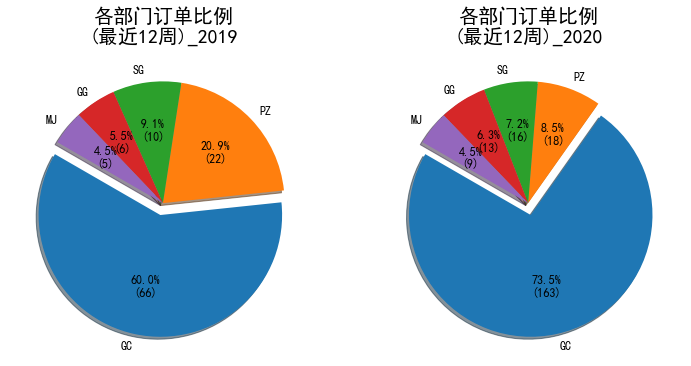

In [12]:
#绘制饼图
import matplotlib as mpl
import numpy as np
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
mpl.rcParams['font.size'] = 12
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1)

def my_label(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

explode = (0.1,0,0,0,0)
plt.pie(dept_2019,autopct= lambda x: my_label(x,dept_2019),explode = explode, labels = dept_2019.index,shadow=True, startangle=150)
plt.title("各部门订单比例\n(最近12周)_2019",fontsize = 20)
# plt.label("2019",fontsize = 14)
ax2 = fig.add_subplot(1,2,2)
plt.pie(dept_2020,autopct= lambda x: my_label(x,dept_2020),explode = explode, labels = dept_2020.index,shadow=True, startangle=150)
plt.title("各部门订单比例\n(最近12周)_2020",fontsize = 20)

plt.savefig('order_byDept.png')